<h3> Learning from Network Project </h3>

<p> This project is a comparative study of three different social media networks:
    <ul>
        <li> <b> Fcebook </b> : This web graph is a page-page graph of verified
                Facebook sites. Nodes represent official Facebook pages while the edges are mutual
                likes between sites. Every node of the graph contains its ID and Facebook’s ID, the
                name of the page, and the page type. The data that generates the graph were
                collected through the Facebook Graph API in November 2017 and restricted to
                pages from 4 categories which are defined by Facebook. These categories are:
                politicians, governmental organizations, television shows and companies.
                The graph contains 22470 nodes and 171002 edges
        <li> <b> GitHub </b> : Nodes are developers who have started at least 10
                repositories and edges are mutual follower relationships between them. Each node of
                the graph contains its ID, the name of the user. The data were collected from the
                public API in June 2019.
                The graph contains 37700 nodes and 289003 edges.
        <li> <b> Twitch </b> : Nodes are Twich’s users and the edges are mutual
                friendships between them. For each node ID, there is a corresponding value of days,
                mature, views, partner, and new_id. The data were collected in May 2018. The graph
                is subdivided into six connected components representing the previous information
                but within different countries.
                This graph contains 34118 nodes and 429113 edges in total.
    </ul>

We will start by studying the global clustering coefficient for every graph, and then foucus on the study on random graphs.
    
</p>

<p> Let us first import the required libraries.
We will import at firts networkx, that contains all the algorithms on graphs. Also we will import pandas for reading the data and matplotlib for visualizing the data.
</p>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random

### Simple graph level features

We need then to read all the graphs. After that, we can compute some graph level features.

In [2]:
def read_graph(graph_path, features_path, name='G', id='id'):
    df = pd.read_csv(graph_path)
    G = nx.from_pandas_edgelist(df, source='id_1', target='id_2', create_using=nx.Graph())

    # remove self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    G.name = name

    G_nodes = pd.read_csv(features_path)
    G_nodes = G_nodes.set_index(id)
    G_nodes = G_nodes.to_dict('index')

    nx.set_node_attributes(G, G_nodes)

    return G



graph_paths = {'facebook': 'facebook_large/complete/musae_facebook_edges.csv', 'git': 'git_web_ml/musae_git_edges.csv', 'twitch': 'twitch/ENGB/musae_ENGB_edges.csv'}
features_paths = {'facebook': 'facebook_large/complete/musae_facebook_target.csv', 'git': 'git_web_ml/musae_git_target.csv', 'twitch': 'twitch/ENGB/musae_ENGB_target.csv'}

Facebook = read_graph(graph_paths['facebook'], features_path=features_paths['facebook'], name='Facebook')
Git = read_graph(graph_paths['git'], features_path=features_paths['git'], name='Git')
Twitch = read_graph(graph_paths['twitch'], features_path=features_paths['twitch'], name='Twitch', id='new_id')

# print a random node to see the attributes
print(Facebook.nodes[0])
print(Git.nodes[0])
print(Twitch.nodes[0])

{'facebook_id': 145647315578475, 'page_name': 'The Voice of China 中国好声音', 'page_type': 'tvshow'}
{'name': 'Eiryyy', 'ml_target': 0}
{'id': 181993475, 'days': 324, 'mature': True, 'views': 1678, 'partner': False}


For each graph we can print some statistics (number of nodes, number of edges, average degree, density)

In [3]:
headers = ["Graph", "Nodes", "Edges", "Avg Degree", "Density"]

Graphs = [Facebook, Git, Twitch]
data = []
for graph in Graphs:
    data.append([graph.name, graph.number_of_nodes(), graph.number_of_edges(), sum(dict(graph.degree()).values()) / graph.number_of_nodes(), nx.density(graph)])

df = pd.DataFrame(data, columns=headers)
print(df)

      Graph  Nodes   Edges  Avg Degree   Density
0  Facebook  22470  170823   15.204539  0.000677
1       Git  37700  289003   15.331724  0.000407
2    Twitch   7126   35324    9.914117  0.001391


<h3> Plot the graphs </h3>

<p> We now need to visualize the graphs. We plot the graph in a way that the more the node is big, the higher is its degree.

We notice a lot of interesting details about the topology of each graph:
<ul>
    <li> <b> Facebook</b>: This seems to be the most connected graph. We can see also, some areas in the graph that have a very high density of edges.
    <li> <b> Git </b>: In this case the graph is less connected than Facebook. This graph contains a lot of nodes with low degree that represent small projects, and some nodes with high degree that represent big projects in which are involved a large number of developers.
    <li> <b> Twich </b>: This graph shares some similarities with the Git graph. The main difference is that in this case there are less edges.
</ul>
</p>

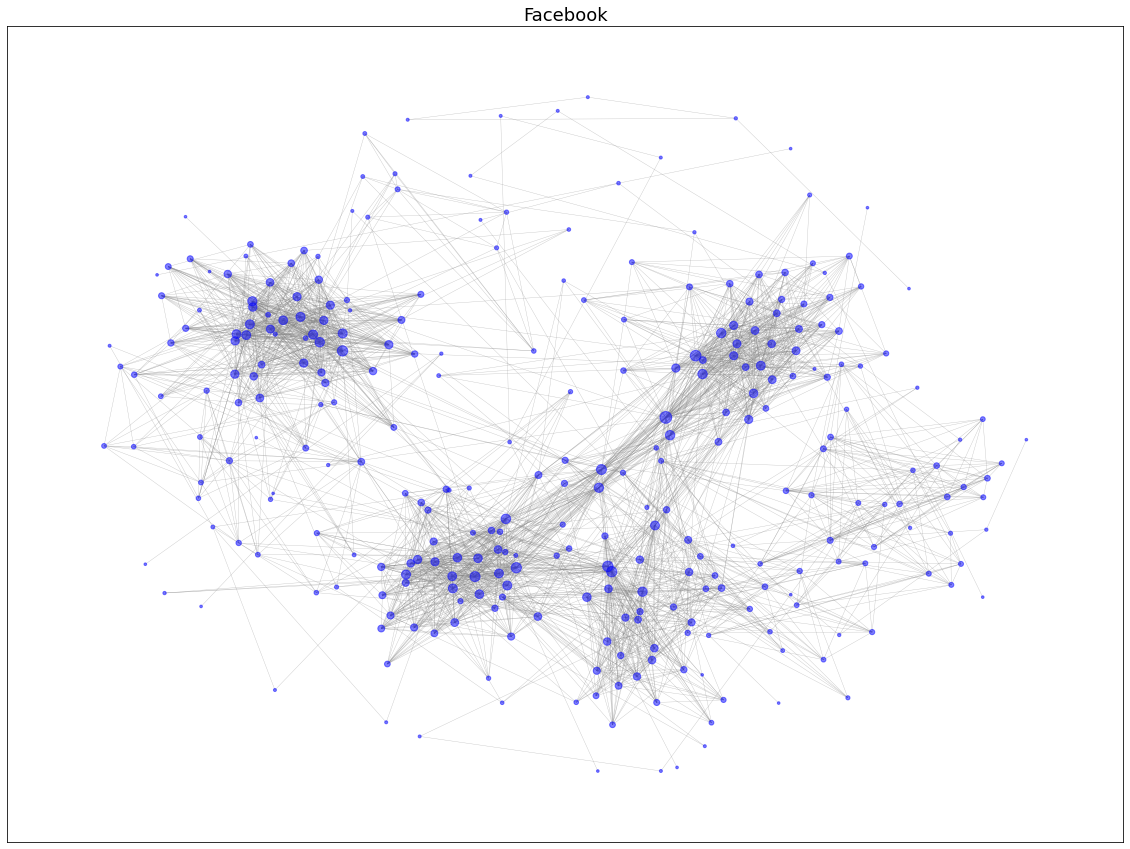

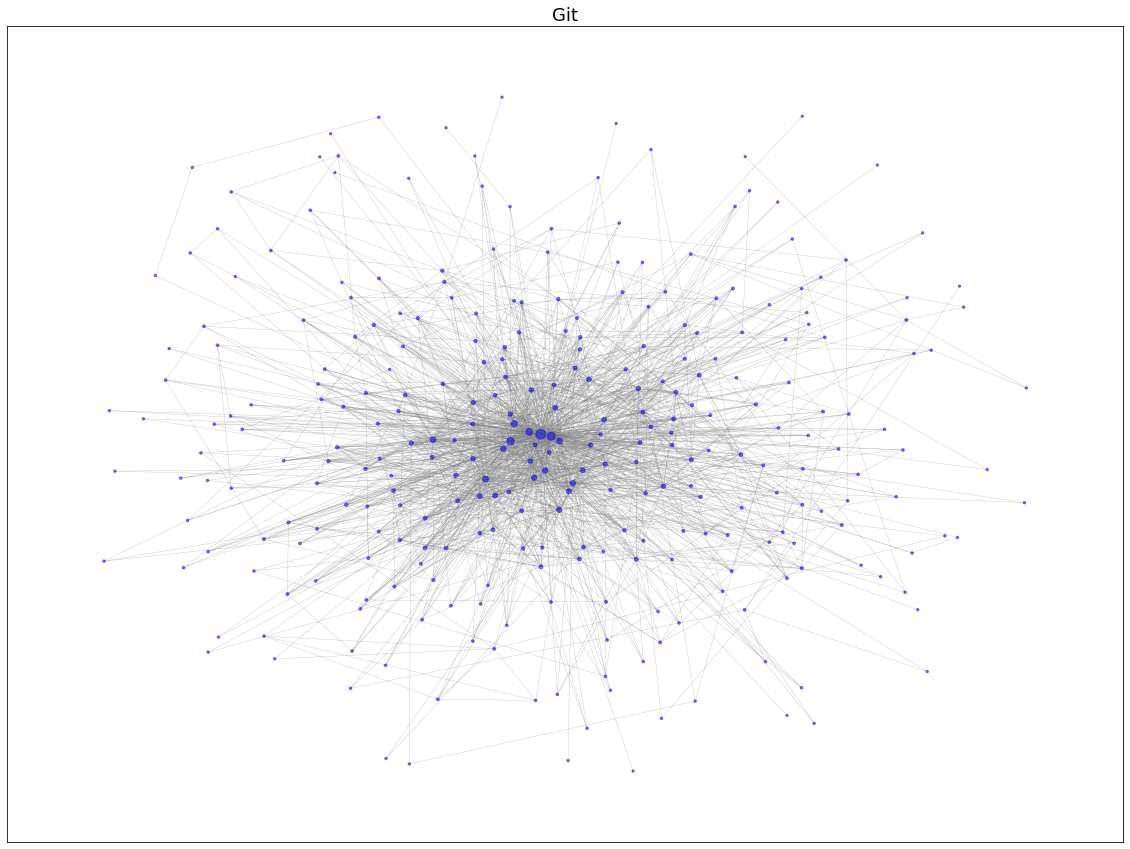

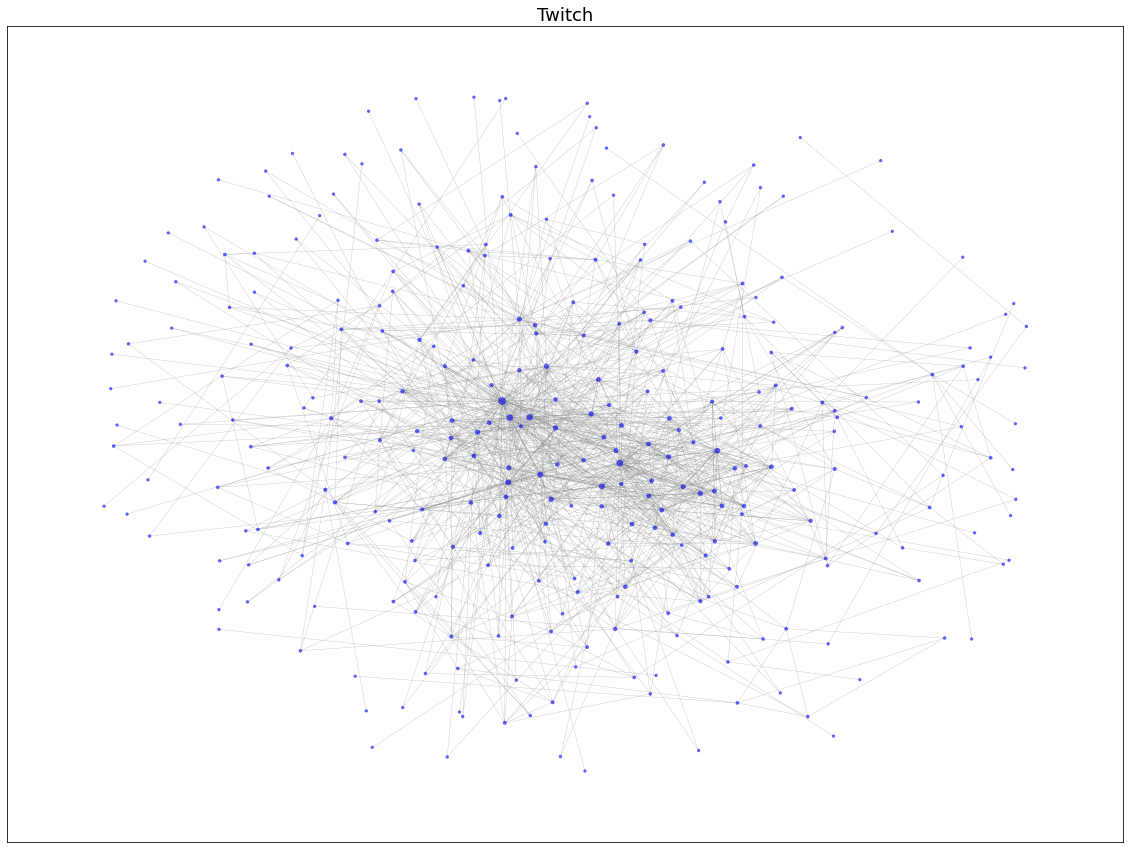

In [7]:
MINIMUM_SIZE = 5

def plot_degree_graph(F, title, size, size_multiplicator=1):
    """
    Plot a subgraph of F in whitch the node size is proportional to the degree
    :param F: the graph
    :param title: the title of the plot
    :param size: the size of the subgraph
    :param size_multiplicator: the multiplicator of the node size
    """
    G = F.subgraph(list(F.nodes())[:size])
    pos = nx.spring_layout(G, k=0.5) # get the position using the spring layout algorithm

    # set the plot parameters
    plt.rcParams['figure.figsize'] = [20, 15]

    sizes = [G.degree(node) * size_multiplicator + MINIMUM_SIZE for node in G]

    # draw the nodes and the edges (all)
    node_color = [G.degree(node) for node in G]
    nx.draw_networkx(G, pos, width=0.35, node_color='blue', edge_color='grey', with_labels=False, alpha=0.5, node_size=sizes)

    plt.title(title, fontsize=18)
    plt.axis('on')
    plt.show()

plot_degree_graph(Facebook, 'Facebook', 300, size_multiplicator=2)
plot_degree_graph(Git, 'Git', 300, size_multiplicator=0.5)
plot_degree_graph(Twitch, 'Twitch', 300, size_multiplicator=0.5)

<h3> Node level Features </h3>

<p> Now we can Compute some simple graph statistics for each graph and then compare them. We can compute the degree centrality in order to find the edges with most degree for each graphs an compare them and the closeness centrality.</p>

In [8]:
closeness_centralities = dict()
for graph in Graphs:
    name = graph.name
    degrees = nx.degree_centrality(graph)

    top_5 = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f'Top 5 nodes with highest degree centrality in {name}:')
    for node, degree in top_5:
        print(f'Node: {graph.nodes[node]}, degree: {degree}')

    closeness = nx.closeness_centrality(graph)
    closeness_centralities[name] = closeness

    top_5 = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f'\nTop 5 nodes with highest closeness centrality in {name}:')
    for node, closeness in top_5:
        print(f'Node: {graph.nodes[node]}, closeness: {closeness}')
    print('\n')

Top 5 nodes with highest degree centrality in Facebook:
Node: {'facebook_id': 44053938557, 'page_name': 'U.S. Army', 'page_type': 'government'}, degree: 0.0315545863189283
Node: {'facebook_id': 1191441824276882, 'page_name': 'The White House', 'page_type': 'government'}, degree: 0.030174907650540747
Node: {'facebook_id': 63811549237, 'page_name': 'The Obama White House', 'page_type': 'government'}, degree: 0.029329298144109662
Node: {'facebook_id': 404391086302925, 'page_name': 'U.S. Army Chaplain Corps', 'page_type': 'government'}, degree: 0.028928746272642306
Node: {'facebook_id': 155837727772692, 'page_name': 'Honolulu District, U.S. Army Corps of Engineers', 'page_type': 'government'}, degree: 0.022430904802171883

Top 5 nodes with highest closeness centrality in Facebook:
Node: {'facebook_id': 20531316728, 'page_name': 'Facebook', 'page_type': 'company'}, closeness: 0.3241578301954844
Node: {'facebook_id': 63811549237, 'page_name': 'The Obama White House', 'page_type': 'government

### Visualize the results

Now we can visualize the results. For each graph, we will plot them such that each node as a color representing its closeness centrality. Then we plot the degree and closeness centrality distribution.

C:\Users\Christian\AppData\Local\Temp\ipykernel_28396\2260092798.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


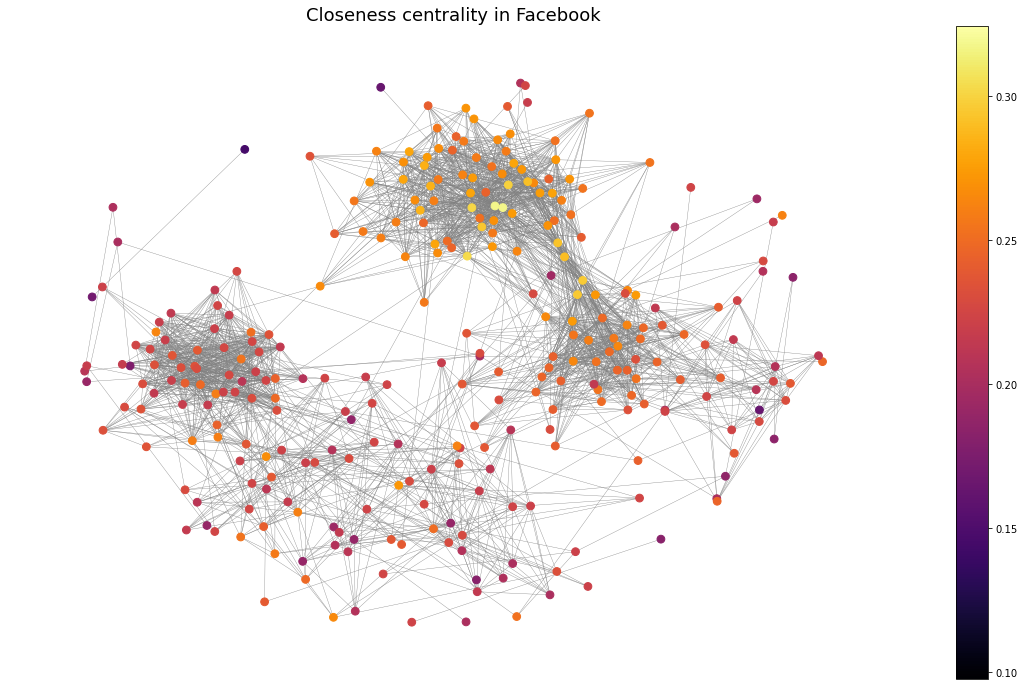

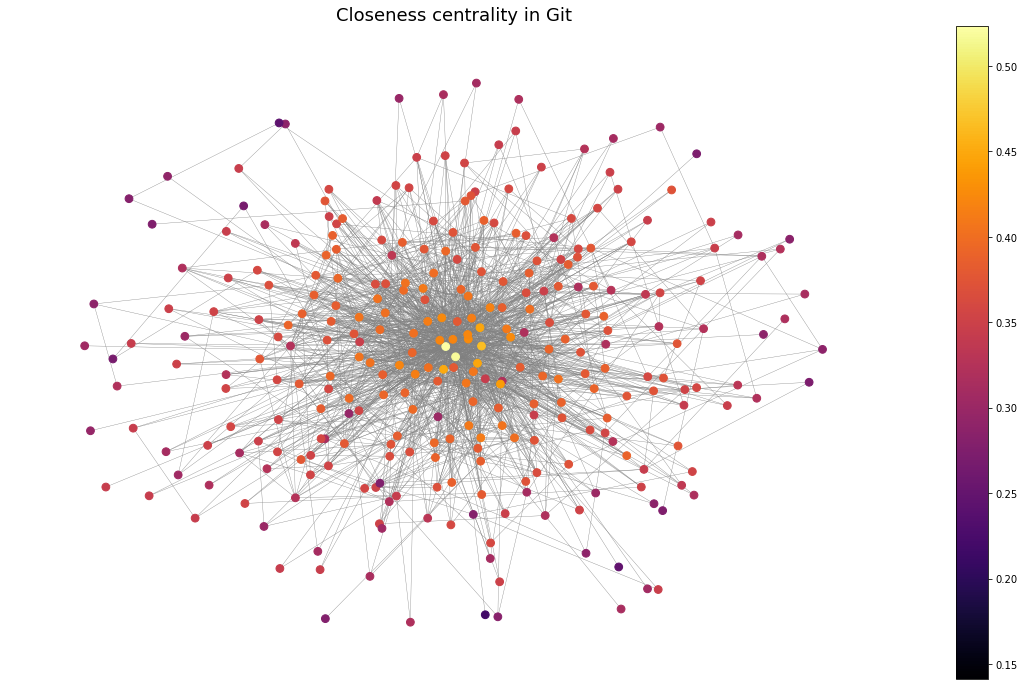

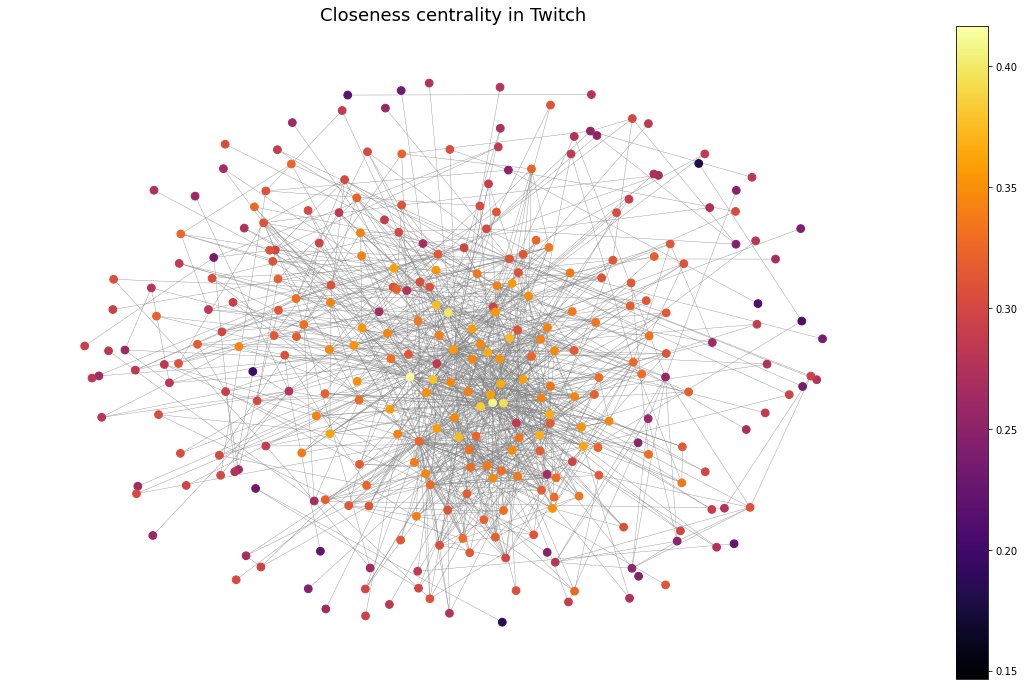

In [9]:
from matplotlib.colors import Normalize

def closeness_centrality_plot(G, title, size, closeness_centrality):
    """
    Plot a subgraph of G in which the node color is a function of the closeness centrality
    :param G: the graph
    :param title: the title of the plot
    :param size: the size of the subgraph
    """
    F = G.subgraph(list(G.nodes())[:size])
    pos = nx.spring_layout(F, k=0.5)  # get the position using the spring layout algorithm

    # set the plot parameters
    plt.rcParams['figure.figsize'] = [20, 12]

    # Choose a colormap (e.g., 'inferno') from Matplotlib
    cmap = plt.cm.get_cmap('inferno')

    # Normalize the closeness centrality values between 0 and 1
    normalized_closeness = plt.Normalize(min(closeness_centrality.values()), max(closeness_centrality.values()))

    # Use the colormap to directly create node colors
    node_color = [cmap(normalized_closeness(closeness_centrality[node])) for node in F]

    # draw the nodes and the edges (all)
    nx.draw_networkx(F, pos, width=0.35, node_color=node_color, edge_color='grey', with_labels=False, node_size=60)

    # draw a lateral colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalized_closeness)
    sm._A = []

    # Specify the location for the colorbar using the 'ax' parameter
    cbar = plt.colorbar(sm, ax=plt.gca())

    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

for graph in Graphs:
    name = graph.name
    closeness_centrality_plot(graph, f'Closeness centrality in {name}', 300, closeness_centralities[name])

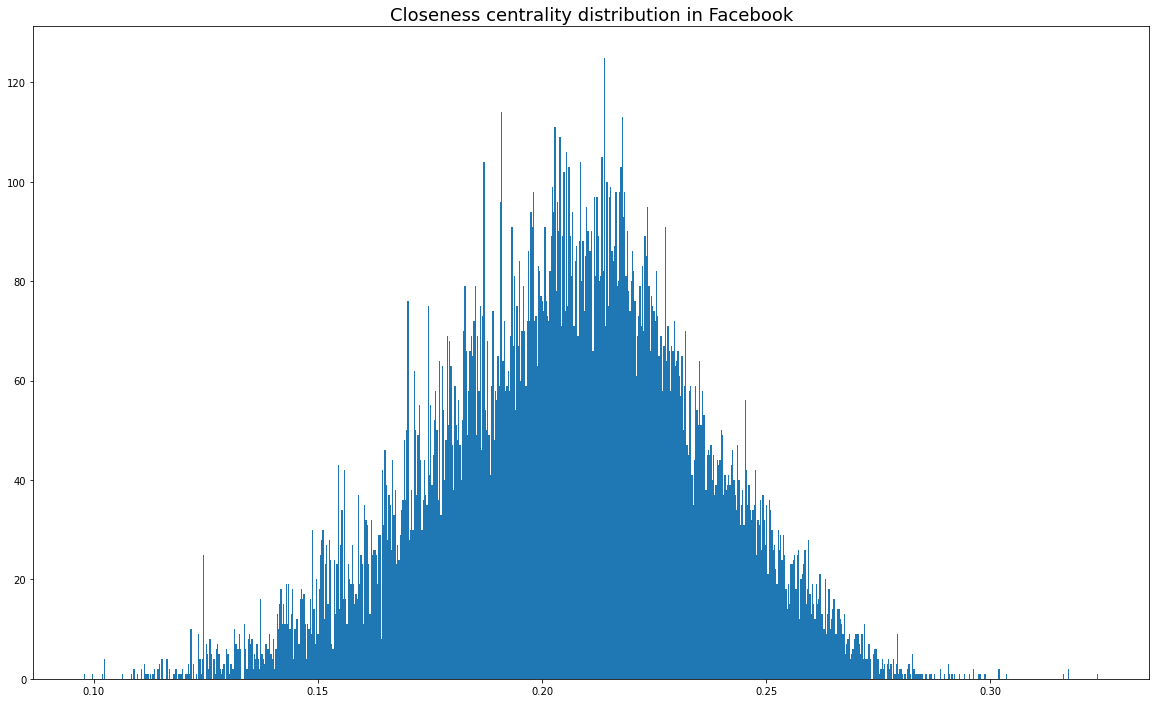

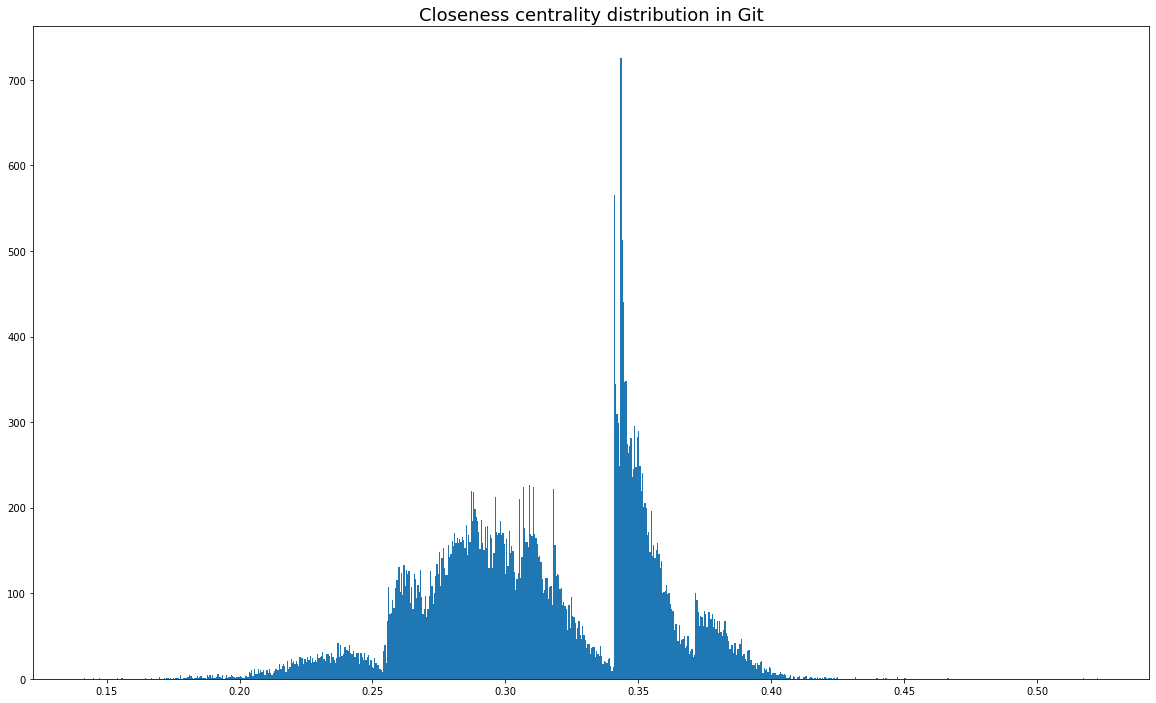

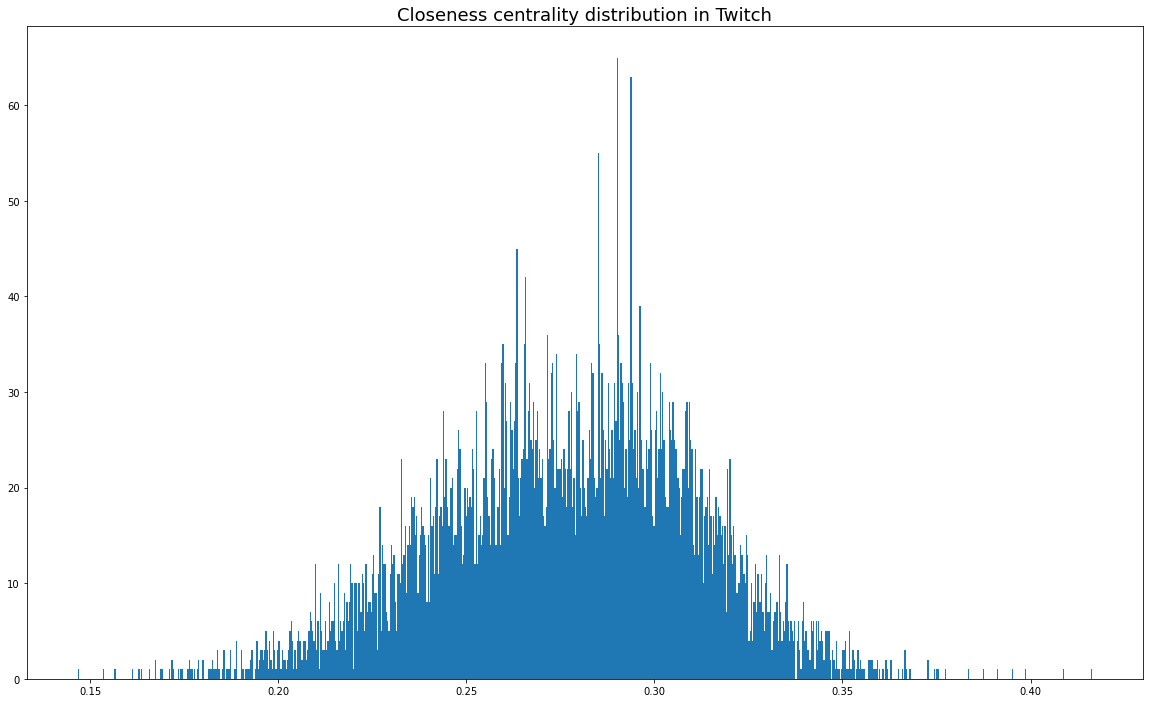

In [14]:
def plot_closeness_centrality_distribution(G, title, size, closeness_centrality):
    """
    Plot the distribution of the closeness centrality
    :param G: the graph
    :param title: the title of the plot
    :param size: the size of the subgraph
    """
    F = G.subgraph(list(G.nodes())[:size])

    # set the plot parameters
    plt.rcParams['figure.figsize'] = [20, 12]

    # Compute the degree centrality of G: deg_cent
    closeness_centralities = list(closeness_centrality.values())

    # Plot a histogram of the degree centrality distribution of the graph
    plt.hist(closeness_centralities, bins=800)

    # Set the plot title
    plt.title(title, fontsize=18)

    # Draw the plot
    plt.show()

for graph in Graphs:
    name = graph.name
    plot_closeness_centrality_distribution(graph, f'Closeness centrality distribution in {name}', 300, closeness_centralities[name])

## Community Detection

This part of the notebook will delve into the study of communities of the Facebook graph. In particular we will analyze and compare two different community detection algorithms:
* __Louvain Community detection__: It is an heuristic method based on modularity optimization. The quality of the partitions is measured in terms of a metric called $modularity$ $\in[-1,1]$ that measures the relative density of edges inside communities with respect to edges outside communities, and is the value to be optimized. For undirected, unweighted networks $G=(V, E)$ (as in our case) the $modularity$ of the graph is defined as:

    $Q = \frac{1}{2m} \sum_{i,j \in V} [A_{ij} - \frac{d_i d_j}{2m}] \delta (c_i, c_j)$

    where:
    - $m = |E|$
    - $A_{ij}$ is the value of the adjacency matrix of $G$.
    - $d_i, d_j$ is the degree of node $i$ and $j$.
    - $c_i, c_j$ are the communities of node $i$ and $j$ respectively.
    - $\delta(x, y)$ is the Kronecker delta function that is equal to $1$ if $x = y$ and $0$ otherwise.

* __Girvan-Newman__ (seen in class): This algorithm produces communities by progressively removing edges with highest link betweenness, defined as:

    $b(e, G) = \sum_{i,j \in V, i\neq j} \frac{\sigma_{i, j} (e)}{\sigma_{i, j}} $

    where:
    - $\sigma_{i, j} (e)$ is the number of shortest paths from node $i$ to node $j$ that pass through edge $e$.
    - $\sigma_{i, j}$ is the number of shortest paths from node $i$ to node $j$.

    The algorithms iterates untill the network is divided into the desired number of communities.

The idea behind the analysis is to find the optimal number of communities of the Facebook graph, using the $modularity$ as a metric. We also want to visualize the partition of the graph in the optimal result and comparing execution time of the algorithms.

We start by analing the Louvain community detection, trying different values of the resolution. But first we need to define some useful functions that we will need later.



In [17]:
import time
import numpy as np

def assign_colors_to_communities(G, communities):
    """
    Assign a color to each community
    :param G: the graph
    :param communities: the communities
    :return: a list of colors
    """
    colors = []
    for node in G:
        for index,community in enumerate(communities):
            if  node in community:
                colors.append(index)
    return colors


def find_index_partion(partition, node):
    """
    Find the index of the community to which the node belongs
    :param partition: the partition
    :param node: the node
    :return: the index of the community
    """
    for index,community in enumerate(partition):
        if  node in community:
            return index

def community_layout(g, partition, in_scale=1, out_scale=9):
    pos_communities = _position_communities(g, partition, out_scale=out_scale)

    pos_nodes = _position_nodes(g, partition, in_scale=in_scale)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, out_scale=9):
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(range(len(partition)))
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)

    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, scale=out_scale, k=0.85)

    # set node positions to position of community
    pos = dict()
    """for node, community in partition.items():
        pos[node] = pos_communities[community]"""
    for i, community in enumerate(partition):
        for node in community:
            pos[node] = pos_communities[i]

    return pos

def _find_between_community_edges(g, partition):
    edges = dict()

    for (ni, nj) in g.edges():
        ci = find_index_partion(partition, ni)
        cj = find_index_partion(partition, nj)

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, in_scale=1):
    communities = dict()
    for i, community in enumerate(partition):
        for node in community:
            try:
                communities[i] += [node]
            except KeyError:
                communities[i] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, scale=in_scale)
        pos.update(pos_subgraph)

    return pos



# function to plot communities in a subgraph
def plot_communities(G, communities, title, perc_nodes, in_scale=1, out_scale=9, node_size=40):
    """
    Plot a subgraph of G in which nodes are colored according to the community they belong to
    :param G: the graph
    :param communities: the communities
    :param title: the title of the plot
    :param perc_nodes: the percentage of nodes to plot
    """
    F = G.subgraph(list(G.nodes())[:int(len(G) * perc_nodes)])
    
    # remove the self loops in F
    F = nx.Graph(F)
    F.remove_edges_from(nx.selfloop_edges(F))

    # pos = nx.spring_layout(F, k=0.3)
    
    pos = community_layout(F, communities, in_scale=in_scale, out_scale=out_scale)

    plt.rcParams['figure.figsize'] = [20, 15]

    # draw the nodes and the edges (all)
    node_color = assign_colors_to_communities(F, communities)
    nx.draw_networkx(F, pos=pos, width=0.5, node_color=node_color, edge_color='grey', with_labels=False, alpha=0.8, node_size=node_size)

    plt.title(title, fontsize=18)
    plt.axis('on')
    plt.show()

def plot_x_y(x, y, title='Bar Graph', xlabel='X-axis', ylabel='Y-axis'):
    """
    Plot a bar graph of y that is a dictionary of lists of y values.

    Parameters:
    - x: List or array-like object representing the x-values.
    - y: dictionary containing the y values for all the elements.
    - title: Title of the bar graph (default is 'Bar Graph').
    - xlabel: Label for the x-axis (default is 'X-axis').
    - ylabel: Label for the y-axis (default is 'Y-axis').

    Returns:
    - None
    """
    # Check if the length of x matches the number of bars for each category in y
    num_bars = len(list(y.values())[0])
    if len(x) != num_bars:
        raise ValueError("Length of x must match the number of bars for each category in y.")

    # Create figure and axis
    fig, ax = plt.subplots()

    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Set the positions for each bar
    bar_positions = np.arange(num_bars)

    # Set the width of the bars
    bar_width = 0.2  # Adjust as needed

    # Plot each set of bars
    for i, (label, values) in enumerate(y.items()):
        ax.bar(bar_positions + i * bar_width, values, width=bar_width, label=label)

    # Set x-axis ticks and labels
    ax.set_xticks(bar_positions + (len(y) - 1) * bar_width / 2)
    ax.set_xticklabels(x)

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
    

Now we will test different values of the resolution. We know that if the resolution is less than 1, the algorithm favors larger communities, while Greater than 1 favors smaller communities. We also study the running time and we will visualize the result of the best partitioning.

Testing Louvain algorithm on Facebook
Resolution: 0.1
Number of communities k = 24
Modularity: 0.637318952255065

Resolution: 0.2
Number of communities k = 22
Modularity: 0.7303165244315704

Resolution: 0.35
Number of communities k = 36
Modularity: 0.7708815570337945

Resolution: 0.5
Number of communities k = 37
Modularity: 0.7894164083559646

Resolution: 0.8
Number of communities k = 56
Modularity: 0.8062185152896508

Resolution: 1.0
Number of communities k = 58
Modularity: 0.8141066874103927

Resolution: 1.5
Number of communities k = 76
Modularity: 0.8102479748007179

Resolution: 3.0
Number of communities k = 109
Modularity: 0.7929038170300747

Resolution: 5.0
Number of communities k = 145
Modularity: 0.7578518942349309

Resolution: 10.0
Number of communities k = 231
Modularity: 0.7009688124873702

Average running time: 3.8850024700164796



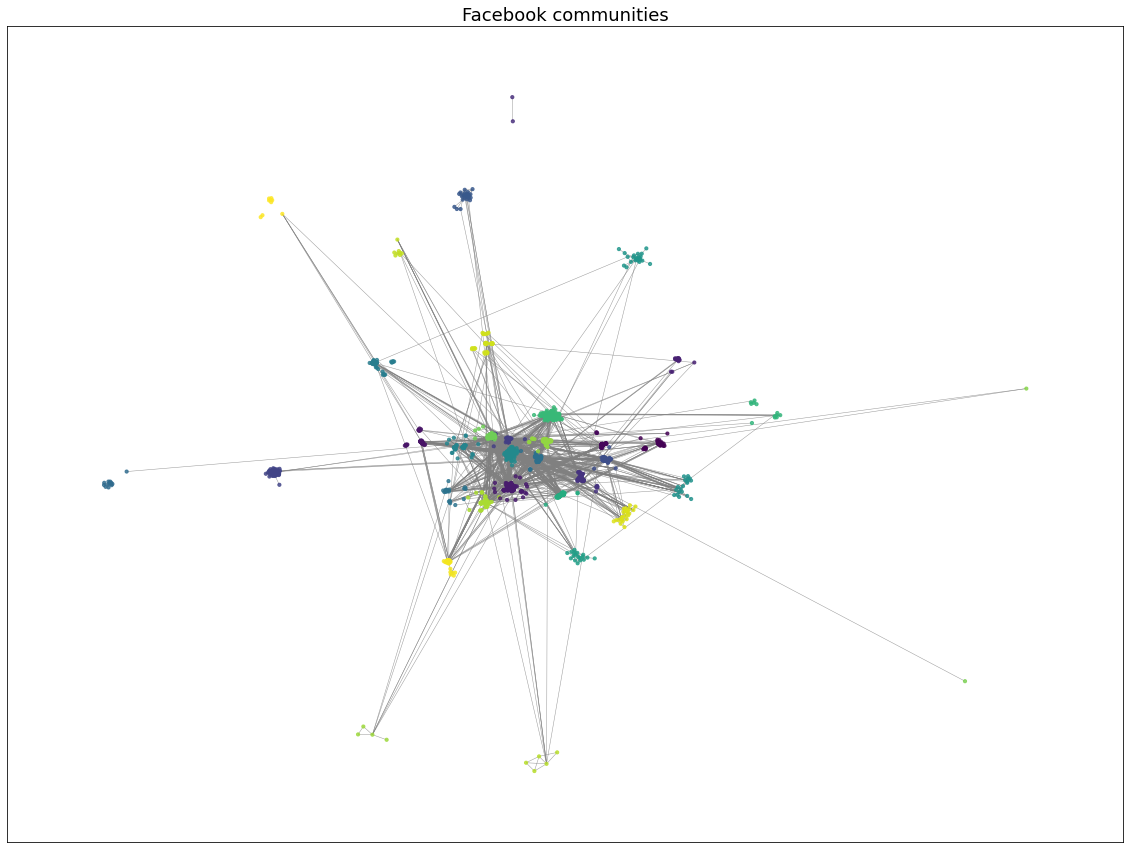

Testing Louvain algorithm on Git
Resolution: 0.1
Number of communities k = 1
Modularity: 0.0

Resolution: 0.2
Number of communities k = 8
Modularity: 0.00016607738796612964

Resolution: 0.35
Number of communities k = 19
Modularity: 0.2748345096980002

Resolution: 0.5
Number of communities k = 148
Modularity: 0.21630526721087928

Resolution: 0.8
Number of communities k = 82
Modularity: 0.4181824547462293

Resolution: 1.0
Number of communities k = 31
Modularity: 0.45125498777301415

Resolution: 1.5
Number of communities k = 34
Modularity: 0.4311397717610601

Resolution: 3.0
Number of communities k = 87
Modularity: 0.39268976312444204

Resolution: 5.0
Number of communities k = 178
Modularity: 0.3399992271677794

Resolution: 10.0
Number of communities k = 410
Modularity: 0.2793785712580432

Average running time: 8.951251554489136



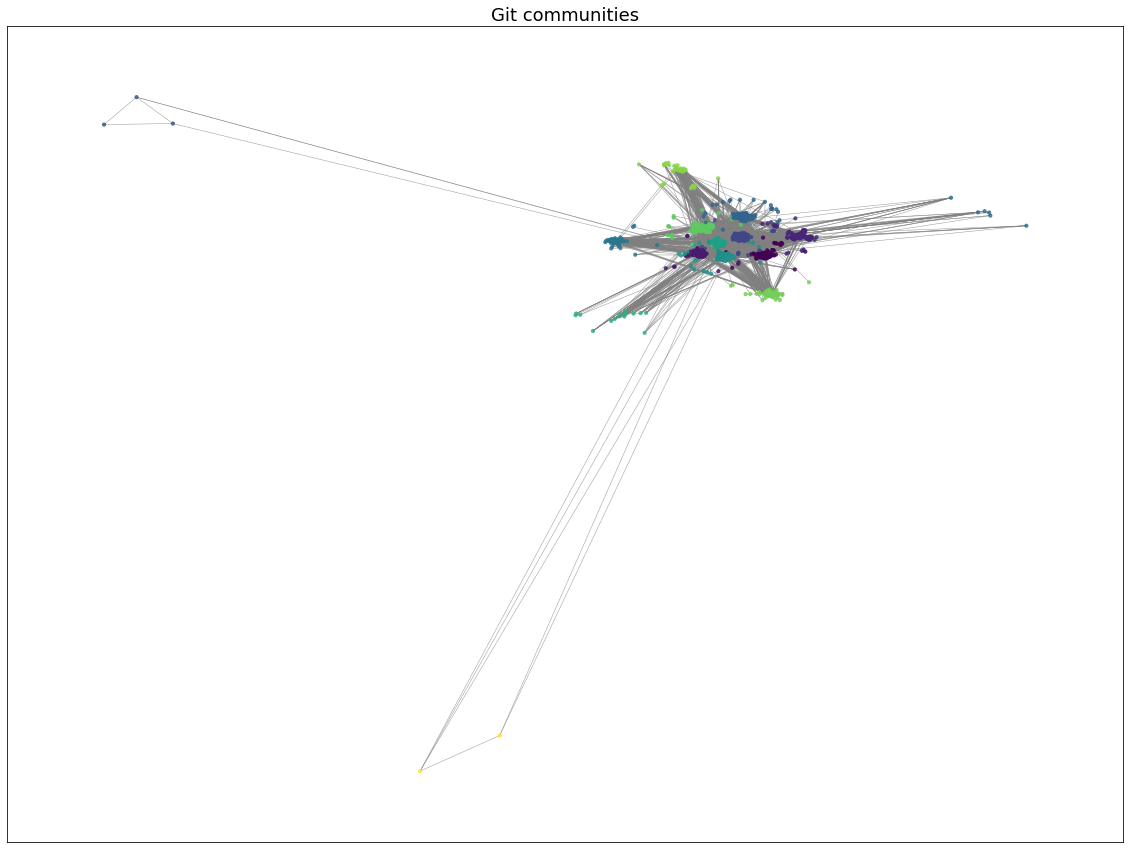

Testing Louvain algorithm on Twitch
Resolution: 0.1
Number of communities k = 1
Modularity: 0.0

Resolution: 0.2
Number of communities k = 2
Modularity: 0.0001698365536338427

Resolution: 0.35
Number of communities k = 21
Modularity: 0.15345952642725202

Resolution: 0.5
Number of communities k = 16
Modularity: 0.4019388301242057

Resolution: 0.8
Number of communities k = 17
Modularity: 0.4474976904995208

Resolution: 1.0
Number of communities k = 20
Modularity: 0.4574573676386371

Resolution: 1.5
Number of communities k = 33
Modularity: 0.44108094350063726

Resolution: 3.0
Number of communities k = 77
Modularity: 0.40652519805623943

Resolution: 5.0
Number of communities k = 133
Modularity: 0.3752276826580416

Resolution: 10.0
Number of communities k = 241
Modularity: 0.3263623219005646

Average running time: 1.1291024923324584



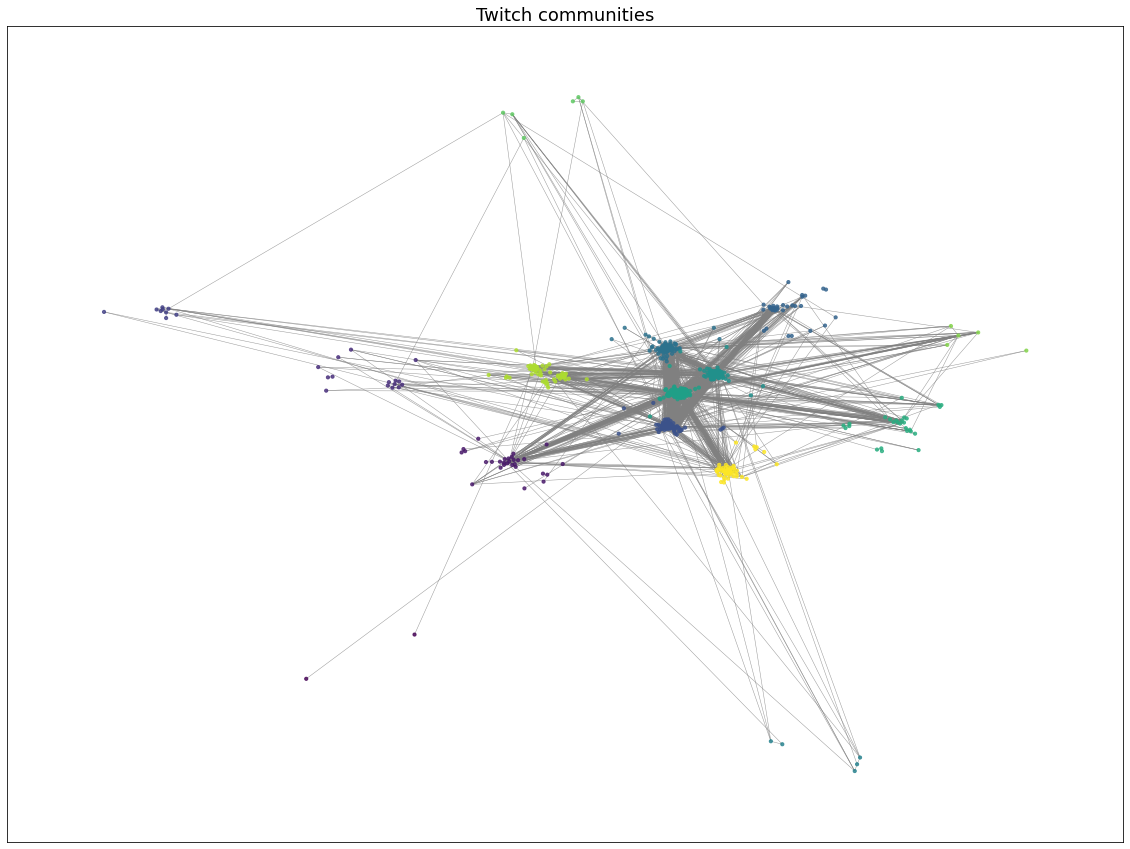

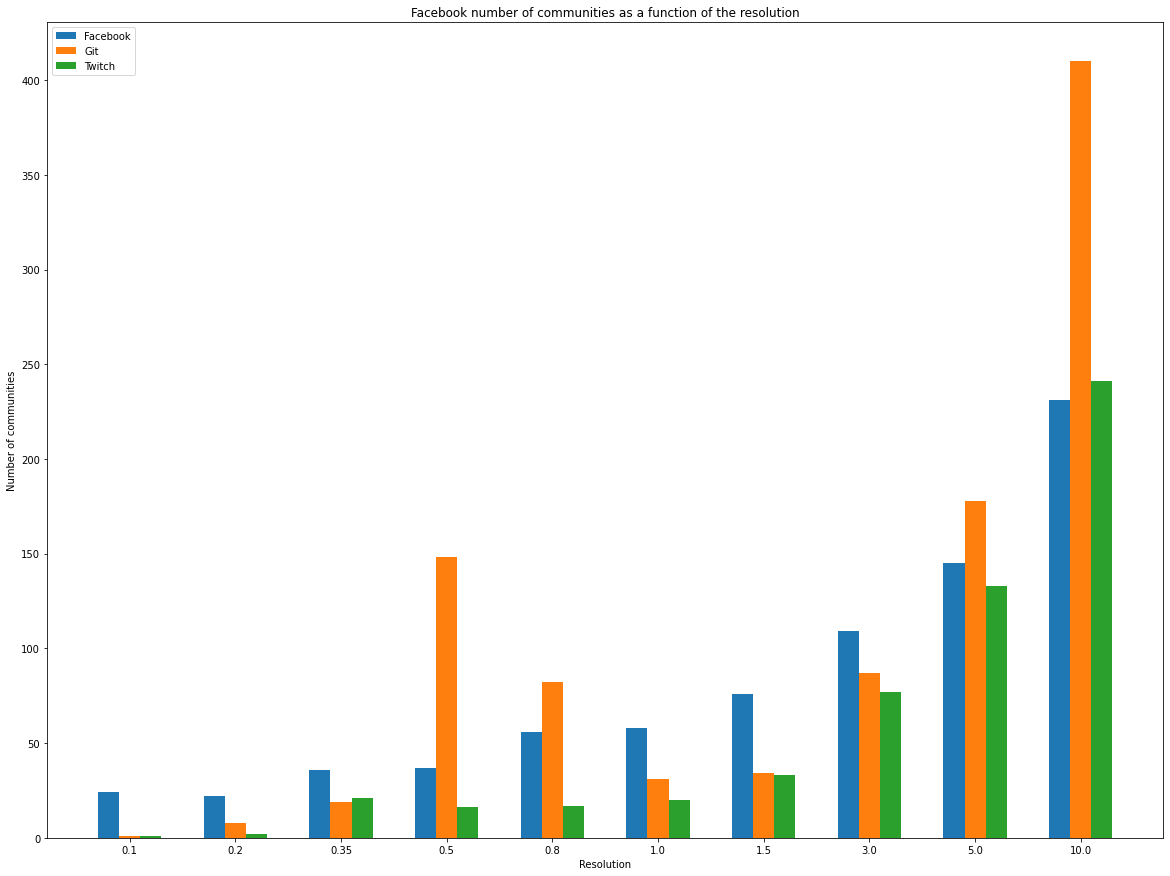

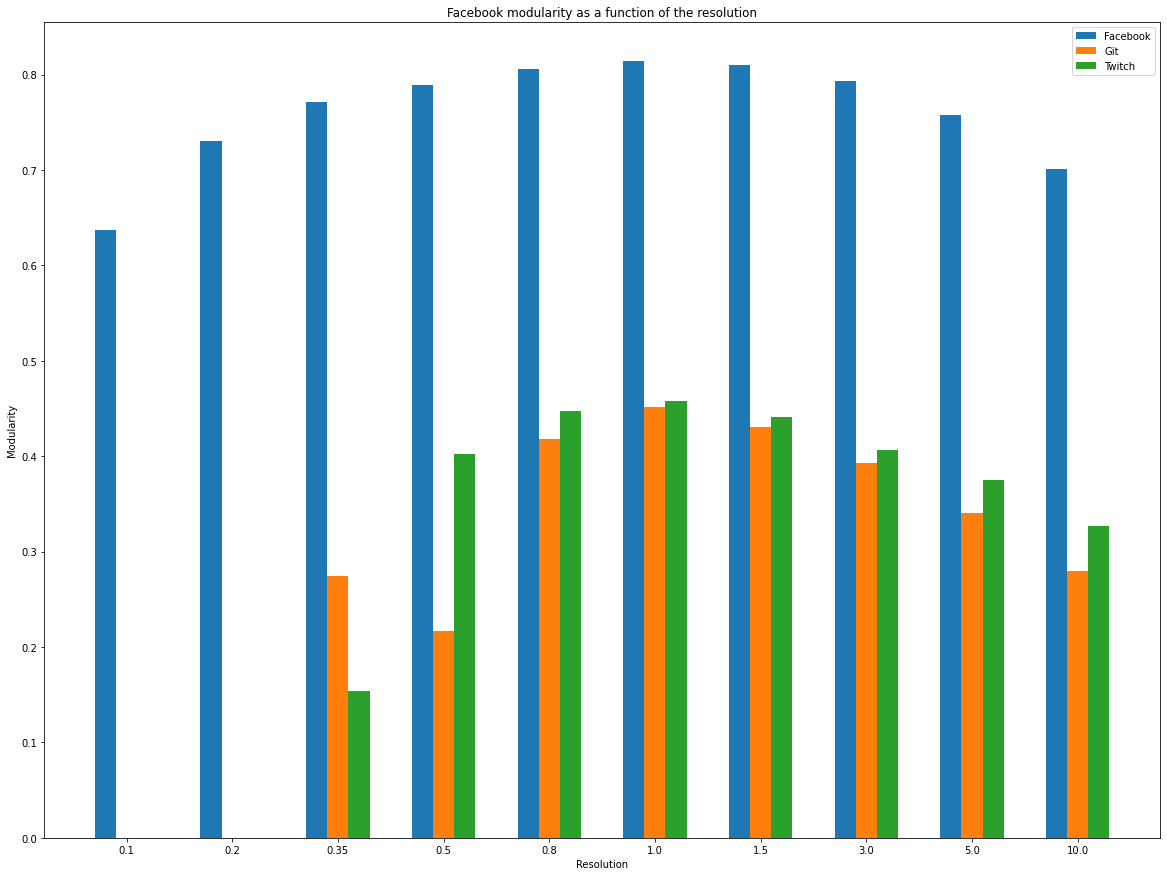

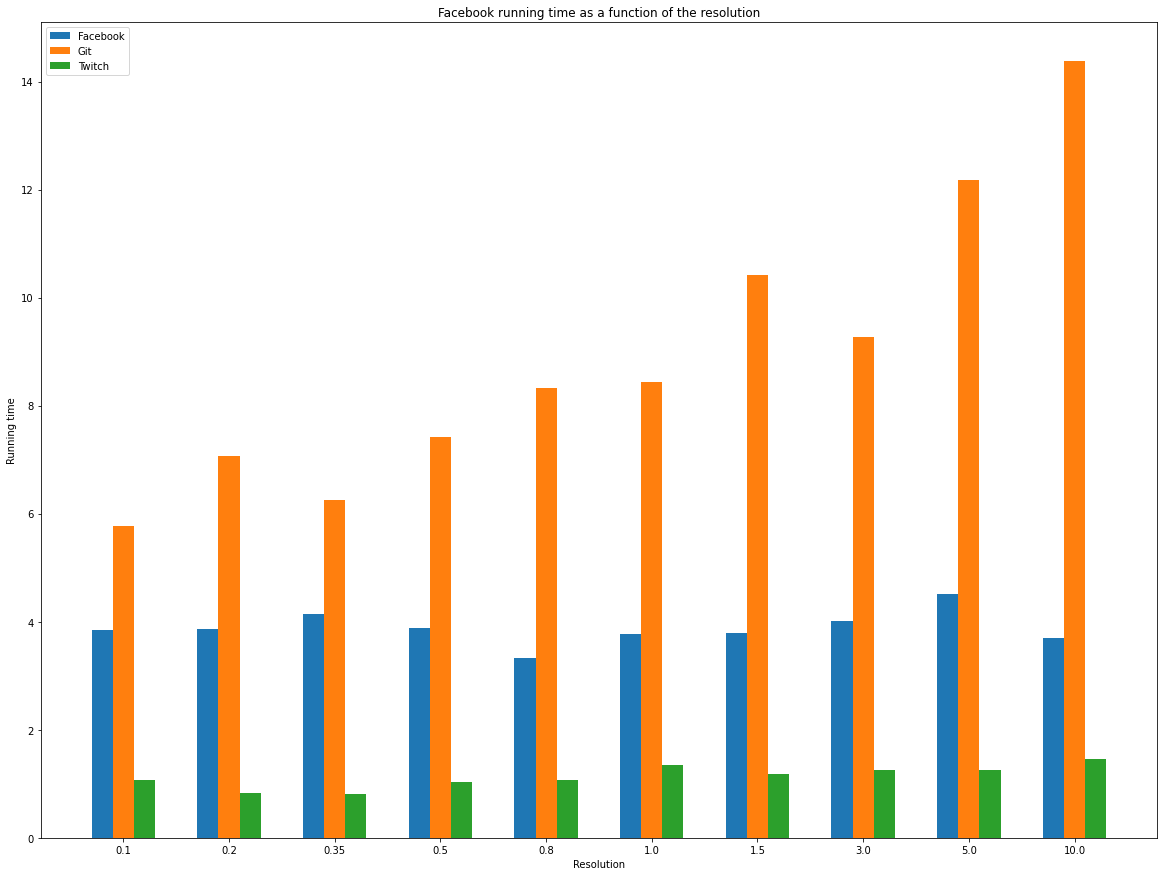

In [18]:
RESOLUTIONS = [0.1, 0.2, 0.35, 0.5, 0.8, 1.0, 1.5, 3.0, 5.0, 10.0]

def louvain_communities(G):
    """
    Find the communities of G using the Louvain algorithm
    :param G: the graph
    """
    print(f'Testing Louvain algorithm on {G.name}')

    total_time = 0
    max_modularity = -1
    times = []
    modularities = []
    num_communities = []
    best_comm = None
    for resolution in RESOLUTIONS:
        start = time.time()
        comm = nx.community.louvain_communities(G, resolution=resolution)
        end = time.time()

        modularity = nx.community.modularity(G, comm)

        print(f'Resolution: {resolution}')
        print(f'Number of communities k = {len(comm)}')
        print(f'Modularity: {modularity}\n')

        modularities.append(modularity)
        times.append(end - start)
        num_communities.append(len(comm))

        if modularity > max_modularity:
            max_modularity = modularity
            best_comm = comm

        total_time += end - start
    

    print(f'Average running time: {total_time / len(RESOLUTIONS)}\n')
    plot_communities(G, best_comm, f'{G.name} communities', 0.1, in_scale=0.01, out_scale=0.3, node_size=10)

    return num_communities, modularities, times

num_communities, modularities, times = dict(), dict(), dict()
for graph in Graphs:
    num_communities[graph.name], modularities[graph.name], times[graph.name] = louvain_communities(graph)

plot_x_y(RESOLUTIONS, num_communities, 'Facebook number of communities as a function of the resolution', 'Resolution', 'Number of communities')
plot_x_y(RESOLUTIONS, modularities, 'Facebook modularity as a function of the resolution', 'Resolution', 'Modularity')
plot_x_y(RESOLUTIONS, times, 'Facebook running time as a function of the resolution', 'Resolution', 'Running time')

Now we will study the Girvan-Newman method. In this case we are able to directly control the number of communities and, thanks to the previous test, we have a clue on the optimal number of communities. In this case the way we treat the output is different than before, since the Girvan-Newman algorithm returns as output a dendogram (in practice an iterator over tuples of set of nodes). We make a proper use of the library itertool to extract the communities. 
The second parameter of the function called **most_valuable_edge** and is the function that determines the removal criterion of the edge, by default it selects the edge with highest betweenness centrality.

Unfortunately, this algorithm perform very slow, also accordingly to the developers of Networkx. The main reason is the exactly computation of the betweenness centrality. So we created an algorithm that approximates it but speeds up the computation by allowing to execute the algorithm on larger graphs in reasonably amount of time.

We will first make some test on the practical performance of the approximation algorithm, using as benchmarks some random subgraph of Facebook, and on the second part we will try to run the approximation algorithm on the overall Fcebook graph. We will use the function **random_partition_graph**, that generates some random graphs divided in partitions and we will compare the Girvan-Newman algorithm with the approximate betweenness centrality and exact betweennee centrality.



In [6]:
import itertools

def random_subset_sum(num, size):
    """
    Generate a random list of numbers such that their sum is num
    :param num: the sum of the numbers
    :param size: the size of the list
    :return: the list of numbers
    """
    l = [random.random() for _ in range(size)]
    s = sum(l)
    p = [int(num * x / s) for x in l[:-1]]
    p.append(num - sum(p))
    return p


def generate_random_subgraph(graph, size):
    """ Generate a random subgraph of the given size from the given graph
    :param graph: the graph
    :param size: the size of the subgraph
    :return: the subgraph
    """
    subgraph_nodes = random.sample(graph.nodes(), size)
    subgraph = graph.subgraph(subgraph_nodes)

    return subgraph


def unfold_communities(comm, num_partitions):
    """Unfold the communities in a list of nodes
    :param comm: an iterable of communities
    :param num_partitions: the number of partitions
    :return: the communities unfolded
    """
    limited = itertools.takewhile(lambda c: len(c) <= num_partitions, comm)

    x = None
    for communities in limited:
        # print(tuple(sorted(c) for c in communities))
        x = list(set(c) for c in communities)

    return x  
    
    

In [7]:
import numpy as np

epsilon = 0.25
test_runs = 8
test_size = 25

def most_central_edge(G):
    """Approximates the betweenness centrality trough sampling in the graph and pick the edge with highest value.
    :param G: the graph
    :return: the edge with highest estimated betweenness centrality if the loop found at least one edge, a random edge otherwise
    """
    APPROXIMATION_ACCURACY = epsilon
    centralities = {} # keep track of the centralities of the edges

    iters = int(2 / APPROXIMATION_ACCURACY ** 2)
    for _ in range(iters):
        # pick 2 random nodes
        s, t = random.sample(G.nodes(), 2)
        # compute the shortest paths between them
        if not nx.has_path(G, source=s, target=t):
            continue
        
        paths = nx.all_shortest_paths(G, source=s, target=t)

        path = random.choice(list(paths))
        for e in zip(path[:-1], path[1:]):
            e = tuple(sorted(e))
            centralities[e] = centralities.get(e, 0) + 1 / iters

    return max(centralities, key=centralities.get) if len(centralities) > 0 else random.choice(list(G.edges))


def plot_comparison(x, y1, y2, title, xlabel, ylabel):
    """
    Plot a comparison between y1 and y2 as a function of x
    :param x: the x values
    :param y1: the y1 values
    :param y2: the y2 values
    :param title: the title of the plot
    :param xlabel: the label of the x axis
    :param ylabel: the label of the y axis
    """
    plt.rcParams['figure.figsize'] = [14, 8]
    plt.plot(x, y1, label='Exact')
    plt.plot(x, y2, label='Approximated')
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(fontsize=16)
    plt.show()


def test_Girvan_Newman(G, num_partitions, approx, eps=0.1):
    """
    Test the Girvan Newman algorithm on the given graph
    :param G: the graph
    :param num_partitions: the number of partitions
    :param approx: 1 if we want to use the approximation, 0 otherwise
    :param eps: the approximation accuracy
    :return: the estimated modularity and the running time
    """
    epsilon = eps
    start = time.time()
    approximated_communities = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge) if approx else nx.community.girvan_newman(G) 
    comm = unfold_communities(approximated_communities, num_partitions)
    end = time.time()

    return nx.community.modularity(G, comm), end - start


C:\Users\Christian\AppData\Local\Temp\ipykernel_14856\435473463.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  s, t = random.sample(G.nodes(), 2)


Approximated modularity: 0.3865174553636232
Exact modularity: 0.3865174553636232

Approximated modularity: 0.14868011109769358
Exact modularity: 0.14868011109769358

Approximated modularity: 0.5493887771087468
Exact modularity: 0.5498296074660884

Approximated modularity: 0.4092731017053429
Exact modularity: 0.23017478936490796

Approximated modularity: 0.3570060737575643
Exact modularity: 0.3570060737575643

Approximated modularity: 0.2667880305613411
Exact modularity: 0.00043867890855961883

Approximated modularity: 0.5446033004161766
Exact modularity: 0.015514477097814582

Approximated modularity: 0.5495077529809117
Exact modularity: 0.5504803595166284



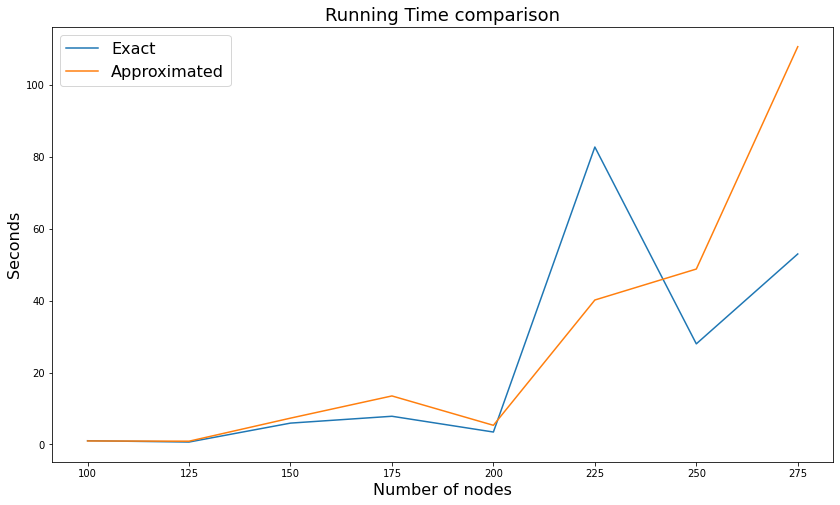

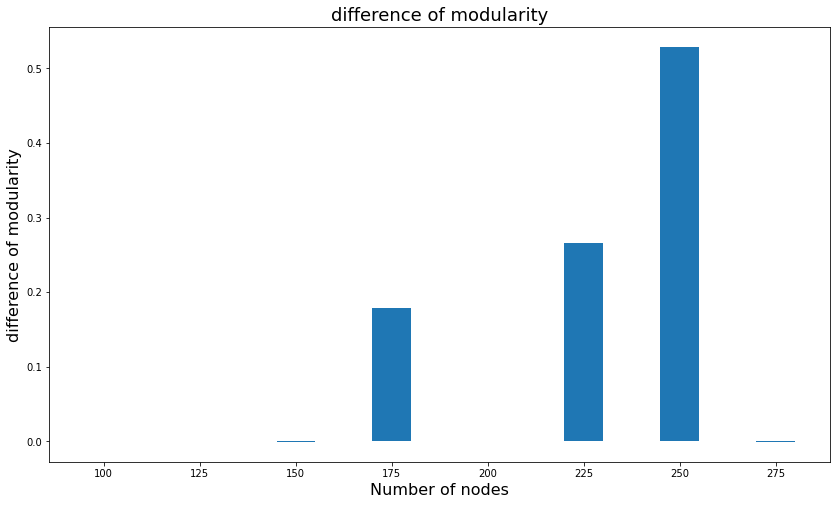

In [9]:
estimated_modularities = []
exact_modularities = []

estimated_times = []
exact_times = []

for i in range(100, 100 + test_runs * test_size, test_size):
    num_partitions = 4
    partition_sizes = random_subset_sum(i, num_partitions)
    prob_in = np.random.normal(0.2, 0.01)
    prob_out = np.random.exponential(scale=0.01)

    Graph = nx.random_partition_graph(partition_sizes, prob_in, prob_out)

    modularity, runtime = test_Girvan_Newman(Graph, num_partitions, approx=1, eps=0.3)
    print(f'Approximated modularity: {modularity}')
    estimated_modularities.append(modularity)
    estimated_times.append(runtime)

    modularity, runtime = test_Girvan_Newman(Graph, num_partitions, approx=0)
    print(f'Exact modularity: {modularity}\n')
    exact_modularities.append(modularity)
    exact_times.append(runtime)


plot_comparison(list(range(100, 100 + test_runs * test_size, test_size)), estimated_times, exact_times, 'Running Time comparison', 'Number of nodes', 'Seconds')

differeces = [estimated_modularities[i] - exact_modularities[i] for i in range(len(estimated_modularities))]

plot_x_y(list(range(100, 100 + test_runs * test_size, test_size)), differeces, 'difference of modularity', 'Number of nodes', 'difference of modularity')

We can now start the community detection on the Facebook graph, using Girvan-Newman with the approximation algorithm for edge-betweenness.

C:\Users\Christian\AppData\Local\Temp\ipykernel_19460\832702480.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  s, t = random.sample(G.nodes(), 2)


Number of communities: 25, modularity: 0.024107821256304673


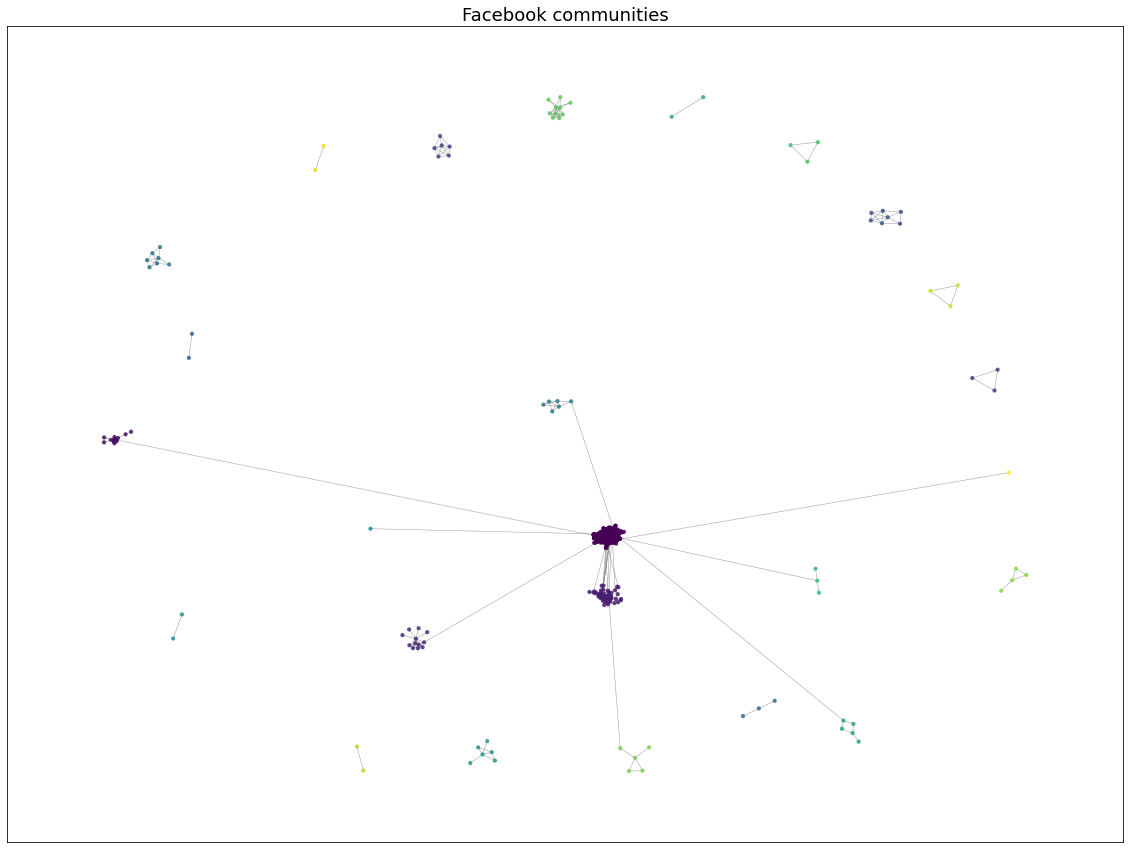

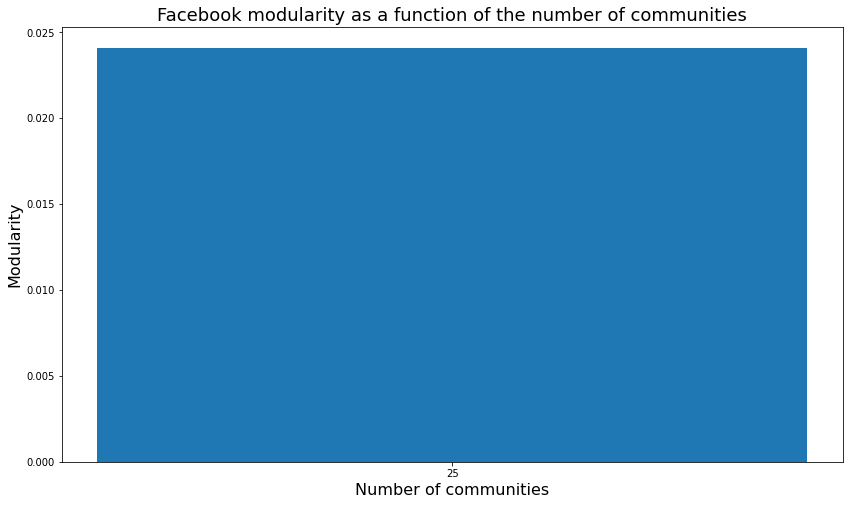

In [48]:
# k = [25, 35, 45, 50, 60, 70, 85, 100, 120, 130, 140]
k = [25]

l = 4000
comp = nx.community.girvan_newman(Facebook.subgraph(list(Facebook.nodes())[:l]), most_valuable_edge=most_central_edge)
limited = itertools.takewhile(lambda c: len(c) <= max(k), comp)

modularities = []
x = None
best_partition = None
for communities in limited:
    # print(tuple(sorted(c) for c in communities))
    x = list(set(c) for c in communities)
    if len(x) in k:
        modularities.append(nx.community.modularity(Facebook.subgraph(list(Facebook.nodes())[:l]), x))
        print(f'Number of communities: {len(x)}, modularity: {modularities[-1]}')
        if modularities[-1] == max(modularities):
            best_partition = x

#print(x)
# plot_degree_graph(Facebook.subgraph(list(Facebook.nodes())[:l]), 'Facebook', l, size_multiplicator=2)
# plot the graph with the communities
plot_communities(Facebook.subgraph(list(Facebook.nodes())[:l]), best_partition, 'Facebook communities', 1.0, in_scale=0.01, out_scale=0.3, node_size=10)
plot_x_y(k, modularities, 'Facebook modularity as a function of the number of communities', 'Number of communities', 'Modularity')